In [706]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from copy import deepcopy as dc
import pickle

import torch
import torch.nn as nn
from  torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import yfinance as  yf  # pip install yfinance


#set plot style
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'lightblue',
    'legend.loc': 'upper left'
})

### Load data - Amazon stock price using yfinance

In [707]:
data = yf.download('AMZN', start='1997-01-01', end=dt.datetime.now())
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...
2024-08-05,154.210007,162.960007,151.610001,161.020004,161.020004,83149400
2024-08-06,161.710007,165.080002,158.539993,161.929993,161.929993,59950800
2024-08-07,166.550003,167.580002,161.429993,162.770004,162.770004,48408200


In [708]:
data = data[['Close']]
data.head()

,Close
Date,
1997-05-15,0.097917
1997-05-16,0.086458
1997-05-19,0.085417
1997-05-20,0.081771
1997-05-21,0.071354


In [709]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

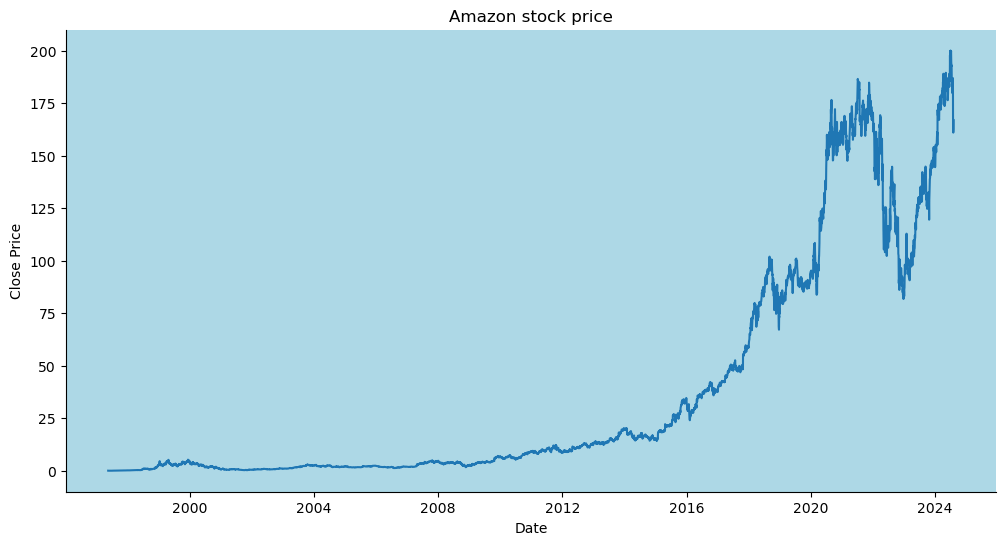

In [710]:
# Data Visualization
plt.figure(figsize=(12,6))
plt.title('Amazon stock price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(data['Close'])
plt.show()


### Data Preprocessing

In [711]:

def modifiy_data_for_lstm(df, lookback):
    df = dc(df)
    for i in range(1, lookback+1):
        df[f'Close_t-{i}'] = df['Close'].shift(i)
        # df[f'Close_t-{lookback+1 - i}'] = df[f'Close'].shift(lookback+1 - i)
    df.dropna(inplace=True)

    return df

lookback = 14
data_lstm = modifiy_data_for_lstm(data, lookback)
data_lstm.head()

,Close,Close_t-1,Close_t-2,Close_t-3,Close_t-4,Close_t-5,Close_t-6,Close_t-7,Close_t-8,Close_t-9,Close_t-10,Close_t-11,Close_t-12,Close_t-13,Close_t-14
Date,,,,,,,,,,,,,,,
1997-06-05,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-06-06,0.082813,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-06-09,0.084375,0.082813,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-06-10,0.079167,0.084375,0.082813,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-11,0.077083,0.079167,0.084375,0.082813,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [712]:
data_lstm_np = data_lstm.to_numpy()
data_lstm_np

array([[7.70829991e-02, 7.08329976e-02, 7.39580020e-02, ...,
        8.54170024e-02, 8.64579976e-02, 9.79169980e-02],
       [8.28130022e-02, 7.70829991e-02, 7.08329976e-02, ...,
        8.17710012e-02, 8.54170024e-02, 8.64579976e-02],
       [8.43750015e-02, 8.28130022e-02, 7.70829991e-02, ...,
        7.13540018e-02, 8.17710012e-02, 8.54170024e-02],
       ...,
       [1.62770004e+02, 1.61929993e+02, 1.61020004e+02, ...,
        1.82550003e+02, 1.83130005e+02, 1.83750000e+02],
       [1.65800003e+02, 1.62770004e+02, 1.61929993e+02, ...,
        1.86410004e+02, 1.82550003e+02, 1.83130005e+02],
       [1.66940002e+02, 1.65800003e+02, 1.62770004e+02, ...,
        1.80830002e+02, 1.86410004e+02, 1.82550003e+02]])

### Scale the data for even information

In [713]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_lstm_scaled = scaler.fit_transform(data_lstm_np)

data_lstm_scaled

array([[-0.99997395, -1.        , -0.99996874, ..., -0.9998437 ,
        -0.99983328, -0.99971865],
       [-0.99991663, -0.99993748, -1.        , ..., -0.99988017,
        -0.9998437 , -0.99983328],
       [-0.999901  , -0.99988016, -0.99993748, ..., -0.99998437,
        -0.99988017, -0.9998437 ],
       ...,
       [ 0.62756135,  0.61916505,  0.61006194, ...,  0.82543912,
         0.83124116,  0.83744327],
       [ 0.65787262,  0.62756814,  0.61916505, ...,  0.8640526 ,
         0.82543912,  0.83124116],
       [ 0.66927686,  0.65787886,  0.62756814, ...,  0.8082331 ,
         0.8640526 ,  0.82543912]])

### Split to train and test sets

In [714]:
X = data_lstm_scaled[:, 1:]
y = data_lstm_scaled[:, 0]

X.shape, y.shape

((6840, 14), (6840,))

In [715]:
X = dc(np.flip(X, axis=1)) # No need to do this if you use df[f'Close_t-{lookback+1 - i}'] = df[f'Close'].shift(lookback+1 - i)
X

array([[-0.99971865, -0.99983328, -0.9998437 , ..., -0.9999531 ,
        -0.99996874, -1.        ],
       [-0.99983328, -0.9998437 , -0.99988017, ..., -0.99996874,
        -1.        , -0.99993748],
       [-0.9998437 , -0.99988017, -0.99998437, ..., -1.        ,
        -0.99993748, -0.99988016],
       ...,
       [ 0.83744327,  0.83124116,  0.82543912, ...,  0.67888621,
         0.61006194,  0.61916505],
       [ 0.83124116,  0.82543912,  0.8640526 , ...,  0.61006194,
         0.61916505,  0.62756814],
       [ 0.82543912,  0.8640526 ,  0.8082331 , ...,  0.61916505,
         0.62756814,  0.65787886]])

In [716]:
split_idx = int(len(X) * 0.95)
X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]


In [717]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6498, 14), (6498,), (342, 14), (342,))

### Prepare data for PyTorch usuage by adding another dimension to the data shape

In [718]:
X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((6498, 14, 1), (6498, 1), (342, 14, 1), (342, 1))

In [719]:
# Create tensors from numpy arrays
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([6498, 14, 1]),
 torch.Size([6498, 1]),
 torch.Size([342, 14, 1]),
 torch.Size([342, 1]))

In [720]:
# Wrap in tensors using pytorch datasets

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [721]:
# Batch the data using DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [722]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 14, 1]) torch.Size([16, 1])


### Define the LSTM model

In [723]:
class LSTM(nn.Module):
    def __init__(self,input_size, hidden_layer, num_stacked_layers):
        super().__init__()
        self.hidden_layer = hidden_layer
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_layer, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_layer).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_layer).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out
    
input_size = 1
hidden_layer = 4
num_stacked_layers = 1

model = LSTM(input_size, hidden_layer, num_stacked_layers).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

### Define the training function

In [724]:
learning_rate = 0.001
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [725]:
def train_one_epoch():
    model.train()
    training_loss = 0

    for idx, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

        if idx % 100 == 0:
            avg_across_batches = training_loss / (idx + 1)
            print(f'Batch: {idx} Loss: {avg_across_batches:.3f}')
           

            training_loss = 0
    print()

In [726]:
def evaluate_one_epoch():
    model.eval()
    evaluation_loss = 0

    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)

            evaluation_loss += loss.item()

    avg_evaluation_loss = evaluation_loss / len(test_loader)

    print(f'Evaluation Loss: {avg_evaluation_loss:.3f}')
    print('**********************************')
    print()

    return avg_evaluation_loss

In [727]:
# Start training
best_loss = np.inf
best_model = None

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    train_one_epoch()
    evaluation_loss = evaluate_one_epoch()

    if evaluation_loss < best_loss:
        best_loss = evaluation_loss
        best_model = dc(model)

print('Training completed')



Epoch: 1/10
Batch: 0 Loss: 0.277
Batch: 100 Loss: 0.172
Batch: 200 Loss: 0.036
Batch: 300 Loss: 0.008
Batch: 400 Loss: 0.002

Evaluation Loss: 0.077
**********************************

Epoch: 2/10
Batch: 0 Loss: 0.001
Batch: 100 Loss: 0.005
Batch: 200 Loss: 0.001
Batch: 300 Loss: 0.000
Batch: 400 Loss: 0.000

Evaluation Loss: 0.010
**********************************

Epoch: 3/10
Batch: 0 Loss: 0.000
Batch: 100 Loss: 0.001
Batch: 200 Loss: 0.000
Batch: 300 Loss: 0.000
Batch: 400 Loss: 0.000

Evaluation Loss: 0.006
**********************************

Epoch: 4/10
Batch: 0 Loss: 0.000
Batch: 100 Loss: 0.000
Batch: 200 Loss: 0.000
Batch: 300 Loss: 0.000
Batch: 400 Loss: 0.000

Evaluation Loss: 0.004
**********************************

Epoch: 5/10
Batch: 0 Loss: 0.000
Batch: 100 Loss: 0.000
Batch: 200 Loss: 0.000
Batch: 300 Loss: 0.000
Batch: 400 Loss: 0.000

Evaluation Loss: 0.003
**********************************

Epoch: 6/10
Batch: 0 Loss: 0.001
Batch: 100 Loss: 0.000
Batch: 200 Loss: 0.

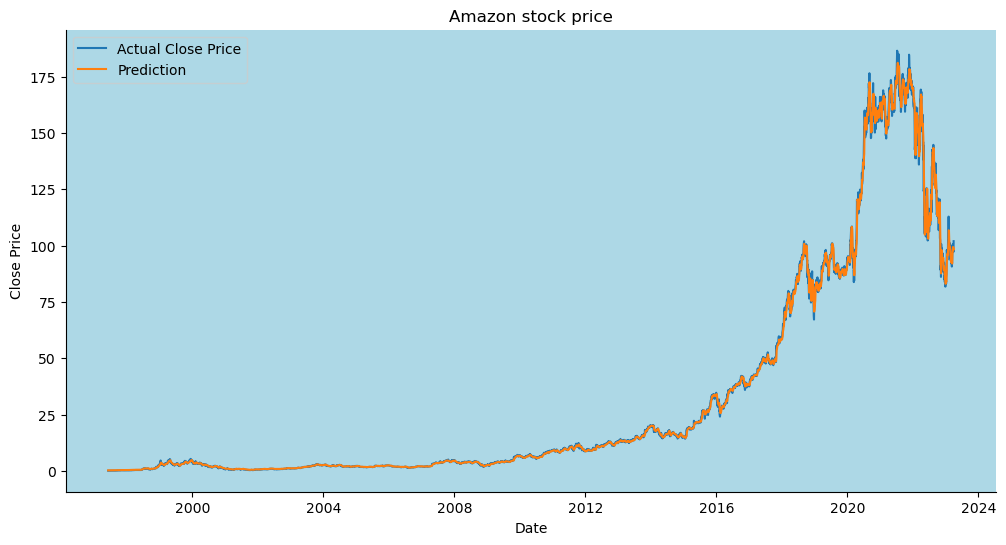

In [728]:
# Prediction for training data
best_model.eval()
with torch.no_grad():
    # y_pred = best_model(torch.tensor(X_train).float().to(device))
    y_pred = best_model(X_train.clone().detach())
    y_pred = y_pred.cpu().numpy()


train_pred = y_pred.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_pred
dummies = scaler.inverse_transform(dummies)

train_pred = dc(dummies[:, 0])
train_pred

dummies2 = np.zeros((X_train.shape[0], lookback+1))
dummies2[:, 0] = y_train.flatten()
dummies2 = scaler.inverse_transform(dummies2)

y_train_inverse = dc(dummies2[:, 0])


# Reverse the date to its original form

date = data_lstm.index
date_train = date[:split_idx]

# Plot the prediction and actual close price uisng the actual date
plt.figure(figsize=(12,6))
plt.title('Amazon stock price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(date_train, y_train_inverse, label='Actual Close Price')
plt.plot(date_train, train_pred, label='Prediction')
plt.legend()
plt.show()

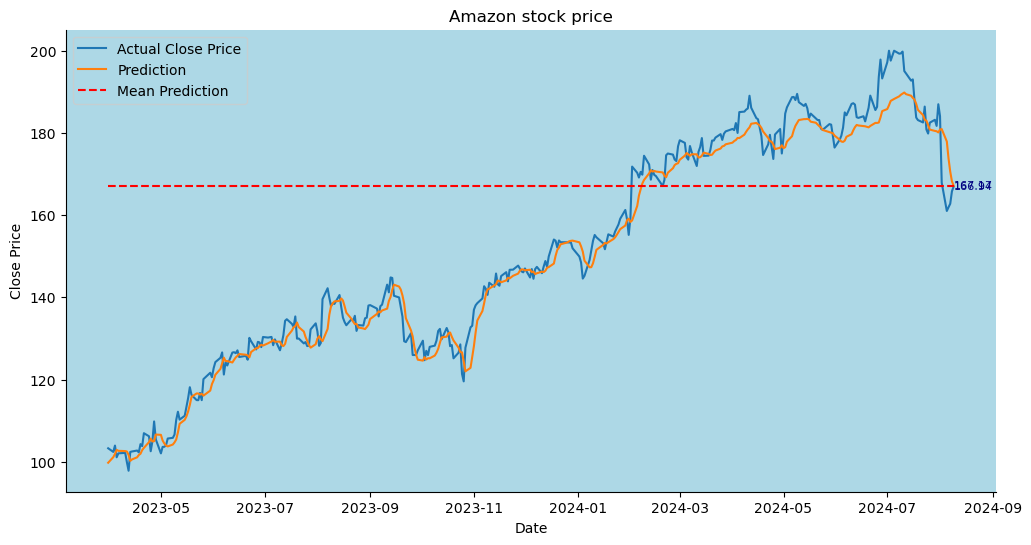

In [730]:
# Prediction for test data
best_model.eval()
with torch.no_grad():
    y_pred = best_model(X_test.clone().detach())
    y_pred = y_pred.cpu().numpy()

test_pred = y_pred.flatten()


dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_pred
dummies = scaler.inverse_transform(dummies)

test_pred = dc(dummies[:, 0])

dummies2 = np.zeros((X_test.shape[0], lookback+1))
dummies2[:, 0] = y_test.flatten()
dummies2 = scaler.inverse_transform(dummies2)

y_test_inverse = dc(dummies2[:, 0])

# Reverse the date to its original form
date_test = date[split_idx:]

# Plot the prediction and actual close price uisng the actual date
plt.figure(figsize=(12,6))
plt.title('Amazon stock price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(date_test, y_test_inverse, label='Actual Close Price')
plt.plot(date_test, test_pred, label='Prediction')
plt.hlines(y=test_pred[-1], xmin=date_test[0], xmax=date_test[-1], color='r', linestyles='--', label='Mean Prediction')
plt.text(date_test[-1], test_pred[-1], f'{test_pred[-1]:.2f}', va='center', ha='left',fontdict={'color':'navy', 'fontsize':8} )
plt.text(date_test[-1], y_test_inverse[-1], f'{y_test_inverse[-1]:.2f}', va='center', ha='left',fontdict={'color':'navy', 'fontsize':8})
plt.legend()
plt.show()


In [734]:
# Save the best model and scaler
torch.save(scaler, 'scaler.pth')
torch.save(best_model, 'best_model.pth')

In [702]:
test_data = data[-lookback*2:]
test_data.to_csv('test_data.csv')
